In [1]:
# Basic module
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from pprint import pprint

# PyTorch
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

In [2]:
# print version of PyTorch
torch.__version__, torchvision.__version__

('1.12.1+cu113', '0.13.1+cu113')

#### Prepare Dataset

*   torch vision datasets: https://pytorch.org/vision/stable/datasets.html

In [3]:
# Define Config
NUM_CLASS = 10

In [4]:

# Build dataset with data preprocess
preprocess = transforms.Compose([transforms.ToTensor()])

train_ds = torchvision.datasets.MNIST('data', 
                                      train=True, 
                                      download=True, 
                                      transform=preprocess)
test_ds = torchvision.datasets.MNIST('data', 
                                     train=False, 
                                     download=True, 
                                     transform=preprocess)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [5]:
# Number of samples
print(len(train_ds), len(test_ds))

60000 10000


#### Build Model

In [6]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

IMG_SIZE = 28

Using cuda


In [7]:
# Define model
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(16, NUM_CLASS),
        )
    def forward(self, x):
        logits = self.net(x)
        return logits

In [8]:
# init model and move to GPU device
model = NeuralNet().to(device)

#### Training: Optimizing the Model Parameters

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.train() # Sets the model in training mode.
    epoch_loss, epoch_correct = 0, 0

    for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
        x, y = x.to(device), y.to(device) # move data to GPU

        # Compute prediction loss
        pred = model(x)
        loss = loss_fn(pred, y)

        # Optimization by gradients
        optimizer.zero_grad() # set prevision gradient to 0
        loss.backward() # backpropagation to compute gradients
        optimizer.step() # update model params

        # write to logs
        epoch_loss += loss.item()
        epoch_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # return avg loss of epoch, acc of epoch
    return epoch_loss/num_batches, epoch_correct/size
    

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # Sets the model in test mode.
    epoch_loss, epoch_correct = 0, 0

    # No training for test data
    with torch.no_grad():
        for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
            x, y = x.to(device), y.to(device)

            pred = model(x)
            loss = loss_fn(pred, y)

            epoch_loss += loss.item()
            epoch_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return epoch_loss/num_batches, epoch_correct/size

# KFold Cross Validation

[scikit-learn Cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html)

[torch.utils.data](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwizs_r_lNDyAhUSBZQKHQGqDl8QFnoECAIQAQ&url=https%3A%2F%2Fpytorch.org%2Fdocs%2Fstable%2Fdata.html&usg=AOvVaw06m6DnMH3sKdb8vc9DGf9b)

[torch.utils.data.SubsetRandomSampler](https://pytorch.org/docs/stable/data.html#torch.utils.data.SubsetRandomSampler)

train model K times with different K fold validation data

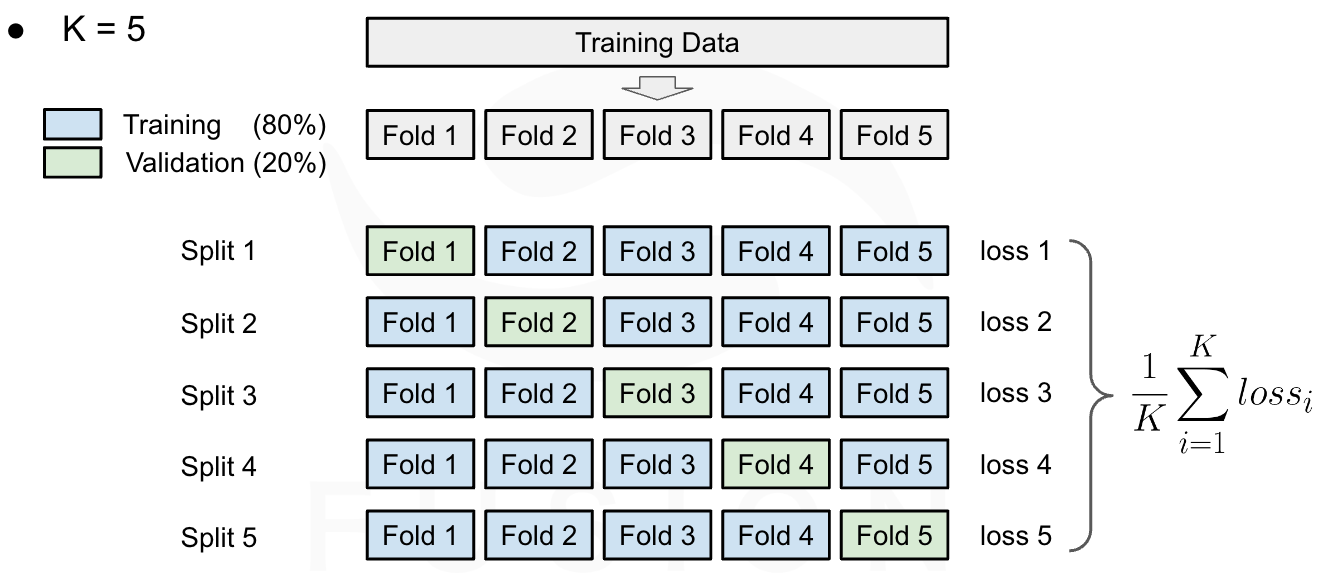

In [10]:
# backup initial weights
PATH = 'init.pth'
torch.save(model.state_dict(), PATH)

In [11]:
K = 5
EPOCHS = 1
BATCH_SIZE = 256
loss_fn = nn.CrossEntropyLoss()
test_loader = torch.utils.data.DataLoader(test_ds, 
                                          batch_size=BATCH_SIZE)

from sklearn.model_selection import KFold
kfold = KFold(n_splits=K)

fold_losses = []
fold_accs = []

for fold_i, (train_ids, val_ids) in enumerate(kfold.split(train_ds)):
    print(f'train size: {len(train_ids)}, val size: {len(val_ids)}')

    # Reset model parameters
    model.load_state_dict(torch.load(PATH))

    # Sample elements from selected ids
    train_sampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_ids)
    # Use sampler to select data for training and validation
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE,
                                               sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE,
                                             sampler=val_sampler)
    
    optimizer = torch.optim.Adam(params=model.parameters())
    # Training
    for epoch in tqdm(range(EPOCHS), leave=False):
        train_loss, train_acc = train(train_loader, model, loss_fn, optimizer)
        val_loss, val_acc = test(val_loader, model, loss_fn)
    
    # Test
    test_loss, test_acc = test(test_loader, model, loss_fn)
    print(f'Fold {fold_i}, test acc: {test_acc:.3f}')

    fold_losses.append(test_loss)
    fold_accs.append(test_acc)

train size: 48000, val size: 12000


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Fold 0, test acc: 0.242
train size: 48000, val size: 12000


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Fold 1, test acc: 0.216
train size: 48000, val size: 12000


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Fold 2, test acc: 0.234
train size: 48000, val size: 12000


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Fold 3, test acc: 0.240
train size: 48000, val size: 12000


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Fold 4, test acc: 0.239


In [12]:
print(f"Loss: mean {np.mean(fold_losses):.3f}, std: {np.std(fold_losses):.3f}")
print(f"Acc: mean {np.mean(fold_accs):.3f}, std: {np.std(fold_accs):.3f}")

Loss: mean 2.082, std: 0.014
Acc: mean 0.234, std: 0.010
